In [1]:
#⚠ Current Business Challenges
#Despite stable logistics costs, the company has experienced deteriorating operational performance:

#📈 The number of delivery delays has increased
#⏳ Average Lead Time has increased
#📉 Service Level (OTD - On-Time Delivery) has begun to decline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

#1 STEP#
#The first step is to load the tables and normalization of data for analysis#

orders = pd.read_excel('Supply_Chain_January_2025.xlsx', sheet_name='Orders_Fact')
costs = pd.read_excel('Supply_Chain_January_2025.xlsx', sheet_name='Monthly_Fixed_Costs')

costs['temp_date'] = pd.to_datetime(dict(year=costs['Year'], month=costs['Month'], day=1))
costs['month'] = costs['temp_date'].dt.to_period('M')
costs = costs.drop(columns=['temp_date'])
costs

,Year,Month,Cost_Type,Amount,month
0,2025,1,Warehouse Rent,25000,2025-01
1,2025,1,IT Systems,6000,2025-01
2,2025,1,Admin Salaries,18000,2025-01
3,2025,1,Marketing,9000,2025-01


In [3]:
orders['Order_Date'] = pd.to_datetime(orders['Order_Date'])
orders['Promised_Date'] = pd.to_datetime(orders['Promised_Date'])
orders['Actual_Delivery_Date'] = pd.to_datetime(orders['Actual_Delivery_Date'])
orders['month'] = orders['Order_Date'].dt.to_period('M')

orders.head(5)

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,Sold_Qty,Price_per_Unit,COGS_per_Unit,Logistics_Cost_per_Unit,Discount_%,month
0,ORD_00001,2025-01-18,2025-01-21,2025-01-20,B2B,HU,WH_B,R02,SKU_H1,Home,7,84.32,38.75,10.57,15,2025-01
1,ORD_00002,2025-01-30,2025-02-01,2025-02-02,Retail,HU,WH_A,R01,SKU_O1,Office,7,105.22,58.08,9.15,5,2025-01
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,4,23.58,14.61,3.33,15,2025-01
3,ORD_00004,2025-01-14,2025-01-16,2025-01-16,Retail,HU,WH_B,R01,SKU_H1,Home,14,38.56,16.60,8.79,15,2025-01
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,14,29.67,13.73,6.91,15,2025-01


In [4]:
#2 STEP# 
#Let's check whether the dataset has outliers, empty rows, or anomalies.#

orders.duplicated().sum()

0

In [5]:
orders.isna().sum()

Order_ID                   0
Order_Date                 0
Promised_Date              0
Actual_Delivery_Date       0
Customer_Type              0
Country                    0
Warehouse                  0
Route_ID                   0
SKU                        0
Category                   0
Sold_Qty                   0
Price_per_Unit             0
COGS_per_Unit              0
Logistics_Cost_per_Unit    0
Discount_%                 0
month                      0
dtype: int64

In [6]:
orders.describe()

,Order_Date,Promised_Date,Actual_Delivery_Date,Sold_Qty,Price_per_Unit,COGS_per_Unit,Logistics_Cost_per_Unit,Discount_%
count,2200,2200,2200,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,2025-01-15 23:35:46.909091072,2025-01-18 23:46:54.545454592,2025-01-18 23:24:39.272727296,10.385909,110.437114,58.106123,7.488127,7.297727
min,2025-01-01 00:00:00,2025-01-03 00:00:00,2025-01-02 00:00:00,1.000000,20.140000,8.210000,3.010000,0.000000
25%,2025-01-08 00:00:00,2025-01-11 00:00:00,2025-01-11 00:00:00,5.000000,66.735000,33.740000,5.157500,0.000000
50%,2025-01-16 00:00:00,2025-01-19 00:00:00,2025-01-19 00:00:00,10.000000,112.020000,57.265000,7.570000,5.000000
75%,2025-01-24 00:00:00,2025-01-27 00:00:00,2025-01-27 00:00:00,15.000000,154.920000,79.807500,9.700000,10.000000
max,2025-01-31 00:00:00,2025-02-04 00:00:00,2025-02-07 00:00:00,20.000000,199.950000,127.250000,11.990000,15.000000
std,NaN,NaN,NaN,5.757308,51.899861,28.711286,2.601753,5.557177


In [7]:
# 3 STEP #
# It is necessary to calculate metrics for further analysis #

orders['Lead Time'] = (orders['Actual_Delivery_Date'] - orders['Order_Date']).dt.days
orders['Delayed'] = (orders['Actual_Delivery_Date'] - orders['Promised_Date']).dt.days
orders['Promised_Lead_Time'] = (orders['Promised_Date'] - orders['Order_Date']).dt.days
orders['In_Time'] = 0
orders.loc[orders['Delayed'] <= 0, 'In_Time'] = 1

orders['Net_Price_per_Unit'] = orders['Price_per_Unit'] * (1-(orders['Discount_%'])*0.01)
orders['Revenue'] = orders['Net_Price_per_Unit']*orders['Sold_Qty']
orders['Gross profit'] = orders['Revenue'] - (orders['COGS_per_Unit']*orders['Sold_Qty'])

#To accurately calculate Net Profit, a two-level data model is used:
#Table 1 — Orders
#Table 2 — Costs
#Since the second table aggregates costs at the monthly (not order) level, I will use the uniform distribution method.

costs_in_january = costs.groupby('month')['Amount'].sum().reset_index(name='total_costs')
total_orders_in_january = orders.groupby('month')['Order_ID'].count().reset_index(name='total_orders')

result = total_orders_in_january.merge(costs_in_january)
result['Extra_costs_per_order'] = result['total_costs']/result['total_orders']
result = result[['month', 'Extra_costs_per_order']]

orders = orders.merge(result)
orders['Net_profit'] = orders['Gross profit'] - (orders['Extra_costs_per_order'] + (orders['Logistics_Cost_per_Unit']*orders['Sold_Qty']))
orders

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,...,month,Lead Time,Delayed,Promised_Lead_Time,In_Time,Net_Price_per_Unit,Revenue,Gross profit,Extra_costs_per_order,Net_profit
0,ORD_00001,2025-01-18,2025-01-21,2025-01-20,B2B,HU,WH_B,R02,SKU_H1,Home,...,2025-01,2,-1,3,1,71.6720,501.704,230.454,26.363636,130.100364
1,ORD_00002,2025-01-30,2025-02-01,2025-02-02,Retail,HU,WH_A,R01,SKU_O1,Office,...,2025-01,3,1,2,0,99.9590,699.713,293.153,26.363636,202.739364
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,...,2025-01,4,0,4,1,20.0430,80.172,21.732,26.363636,-17.951636
3,ORD_00004,2025-01-14,2025-01-16,2025-01-16,Retail,HU,WH_B,R01,SKU_H1,Home,...,2025-01,2,0,2,1,32.7760,458.864,226.464,26.363636,77.040364
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,...,2025-01,4,0,4,1,25.2195,353.073,160.853,26.363636,37.749364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,ORD_02196,2025-01-26,2025-01-28,2025-01-29,B2B,HU,WH_A,R03,SKU_E2,Electronics,...,2025-01,3,1,2,0,41.6385,666.216,315.656,26.363636,206.252364
2196,ORD_02197,2025-01-04,2025-01-08,2025-01-07,Retail,HU,WH_B,R01,SKU_H2,Home,...,2025-01,3,-1,4,1,134.9010,1214.109,568.629,26.363636,449.925364
2197,ORD_02198,2025-01-15,2025-01-19,2025-01-18,Retail,PL,WH_A,R04,SKU_O2,Office,...,2025-01,3,-1,4,1,123.2460,2341.674,1123.394,26.363636,915.580364
2198,ORD_02199,2025-01-28,2025-01-31,2025-01-31,Retail,CZ,WH_A,R01,SKU_E3,Electronics,...,2025-01,3,0,3,1,20.1700,121.020,57.960,26.363636,10.776364


In [8]:
# 4 STEP #
#Before starting the analysis, let's see if there are any unprofitable orders in the dataset based on Net Profit #

def Profit_flag(arg):
    if arg < 0:
        return 'Critically low profitability'
    elif arg < 50:
        return 'Low profit'
    elif arg < 500:
        return 'Stability profit'
    else:
        return 'Perfect profit'

orders['Profit_flag'] = orders['Net_profit'].apply(Profit_flag)
orders.groupby('Profit_flag').size()

# The initial analysis revealed that 20% of orders generated negative net profit.
# This indicator is a significant deviation and may indicate structural problems in unit economics, pricing, or cost allocation.
# However, at this stage, the priority of the analysis has shifted to the operational issue—the decline in Service Level (SLA/OTD), so I'll focus on that for now.

Profit_flag
Critically low profitability     150
Low profit                       289
Perfect profit                   593
Stability profit                1168
dtype: int64

In [9]:
red_orders = orders[(orders['Profit_flag'] == 'Critically low profitability')|(orders['Profit_flag'] == 'Low profit')]
red_orders.head(5)
#For the future, I will prepare a dataset with unprofitable orders.

,Order_ID,Order_Date,Promised_Date,Actual_Delivery_Date,Customer_Type,Country,Warehouse,Route_ID,SKU,Category,...,Lead Time,Delayed,Promised_Lead_Time,In_Time,Net_Price_per_Unit,Revenue,Gross profit,Extra_costs_per_order,Net_profit,Profit_flag
2,ORD_00003,2025-01-10,2025-01-14,2025-01-14,Retail,HU,WH_B,R02,SKU_O2,Office,...,4,0,4,1,20.0430,80.1720,21.7320,26.363636,-17.951636,Critically low profitability
4,ORD_00005,2025-01-01,2025-01-05,2025-01-05,B2B,SK,WH_B,R04,SKU_E3,Electronics,...,4,0,4,1,25.2195,353.0730,160.8530,26.363636,37.749364,Low profit
6,ORD_00007,2025-01-04,2025-01-08,2025-01-08,B2B,HU,WH_A,R03,SKU_E3,Electronics,...,4,0,4,1,31.5180,472.7700,184.1700,26.363636,43.206364,Low profit
7,ORD_00008,2025-01-30,2025-02-02,2025-02-04,Retail,CZ,WH_B,R04,SKU_H2,Home,...,5,2,3,0,127.6105,127.6105,66.6905,26.363636,34.586864,Low profit
8,ORD_00009,2025-01-19,2025-01-23,2025-01-24,Retail,SK,WH_A,R01,SKU_H2,Home,...,5,1,4,0,30.7900,123.1600,72.8400,26.363636,15.596364,Low profit


In [10]:
# 5 STEP #
#To determine when a problem arises, it is necessary to move from an aggregated monthly analysis to the daily dynamics of key metrics.

#The goal is to identify:
# The period when the degradation of indicators began
# Which metrics began to change first
# Whether the problem was gradual or sudden

orders.groupby('Order_Date')[['Net_profit', 'Sold_Qty', 'Lead Time' , 'Delayed']].mean()

#Based on the structural break identified on January 15, 2025, the following hypotheses are developed...
#Hypothesis 1.
#After January 15, 2025, the average actual deviation from the promised delivery date (delay time) increased. This led to an increase in the actual lead time and a mechanical decrease in the OTD metric, which collectively led to a deterioration in the overall service level agreement (SLA).

#Hypothesis 2.
#The increase in delays is uneven: a small proportion of operational combinations +- 20% (Route + WH + Country + Category) contributes disproportionately to the increase in lead time after January 15 (~80%).
#(In other words, the problem may be localized rather than systemic, and concentrated in specific segments of the operational chain.)

#Hypothesis 3.
#The deterioration in SLA is associated with an external or structural change in the process after January 15, 2025 (e.g., a change in transport contractor, a change in routing, a redistribution of workload between warehouses, or a change in cut-off times).

,Net_profit,Sold_Qty,Lead Time,Delayed
Order_Date,,,,
2025-01-01,326.825489,9.838235,2.544118,-0.529412
2025-01-02,364.385394,10.276923,2.338462,-0.476923
2025-01-03,309.704119,10.272727,2.431818,-0.534091
2025-01-04,347.898055,10.136986,2.438356,-0.520548
2025-01-05,371.365829,10.180556,2.444444,-0.472222
2025-01-06,407.497697,10.853333,2.760000,-0.453333
2025-01-07,441.082254,11.939024,2.634146,-0.439024
2025-01-08,270.060817,8.661538,2.446154,-0.476923
2025-01-09,375.009625,11.149254,2.701493,-0.402985


In [11]:
# 6 STEP #
#I will check the first hypothesis and calculate the OTD.

in_time = orders[orders['In_Time'] == 1].groupby('Order_Date')['In_Time'].count().reset_index()
delayed = orders[orders['In_Time'] == 0].groupby('Order_Date')['In_Time'].count().reset_index(name='delayed')

OTD_check = in_time.merge(delayed, how='left')
OTD_check.loc[OTD_check['delayed'].isna(), 'delayed'] = 0
OTD_check['OTD(%)'] = (OTD_check['In_Time']/(OTD_check['In_Time'] + OTD_check['delayed']))*100
OTD_check 
#The data indicates a structural break on January 15, 2025, after which a sharp decline in OTD is observed. 
# Hypothesis 1 is confirmed.
#To conduct a deeper and more accurate analysis, the dataset should be divided into two distinct periods: before and after January 15.

,Order_Date,In_Time,delayed,OTD(%)
0,2025-01-01,68,0.0,100.000000
1,2025-01-02,65,0.0,100.000000
2,2025-01-03,88,0.0,100.000000
3,2025-01-04,73,0.0,100.000000
4,2025-01-05,72,0.0,100.000000
5,2025-01-06,75,0.0,100.000000
6,2025-01-07,82,0.0,100.000000
7,2025-01-08,65,0.0,100.000000
8,2025-01-09,67,0.0,100.000000
9,2025-01-10,62,0.0,100.000000


In [12]:
# 7 STEP #
# I divide the data into 2 groups: Before the 15th and After #

before_problem = orders[orders['Order_Date'] <= '2025-01-15']
after_problem = orders[orders['Order_Date'] > '2025-01-15']

In [13]:
# 8 STEP #
#To evaluate the potential financial impact of the operational shift, we will compare key metrics before and after January 15, examining whether the increase in Lead Time translated into changes in revenue or net profit.

print(before_problem[['Revenue', 'Gross profit', 'Sold_Qty', 'Net_profit', 'Lead Time']].mean())
print('    ')
print(after_problem[['Revenue', 'Gross profit', 'Sold_Qty', 'Net_profit', 'Lead Time']].mean())

# Following the increase in Lead Time, financial metrics (Revenue and Net Profit) showed no significant changes. This suggests that the operational deterioration has not yet resulted in a direct financial impact and that the problem is primarily process-related.
#Next, it would be appropriate to test the second hypothesis and focus on analyzing the operational combinations (Route + Warehouse + Country + Category) that may have contributed disproportionately to the increase in Lead Time after January 15.

Revenue         1082.376400
Gross profit     468.080411
Sold_Qty          10.521287
Net_profit       362.598970
Lead Time          2.509934
dtype: float64
    
Revenue         1039.269353
Gross profit     448.802940
Sold_Qty          10.260717
Net_profit       345.473416
Lead Time          3.438320
dtype: float64


In [14]:
# 9 STEP #
# For a more detailed analysis, a sample of 50 random transaction combinations will be generated for each period (before and after January 15). 
#For each combination, the dynamics of lead time and delay levels will be assessed.

print(before_problem.groupby(['Country', 'Warehouse', 'Route_ID', 'Category'])[['Lead Time', 'Delayed']].mean().reset_index().sample(50)) #LT is stable in 2-3 days, no delays, even all combinations are delivered ahead of schedule.
print('')
print('')
print(after_problem.groupby(['Country', 'Warehouse', 'Route_ID', 'Category'])[['Lead Time', 'Delayed']].mean().reset_index().sample(50)) #The increase in Lead Time affected almost all combinations.

   Country Warehouse Route_ID     Category  Lead Time   Delayed
63      PL      WH_B      R02  Electronics   2.812500 -0.500000
69      PL      WH_B      R04  Electronics   2.400000 -0.600000
79      SK      WH_A      R03         Home   2.625000 -0.500000
30      HU      WH_A      R03  Electronics   2.545455 -0.454545
8       CZ      WH_A      R03       Office   2.285714 -0.285714
77      SK      WH_A      R02       Office   2.500000 -0.416667
75      SK      WH_A      R02  Electronics   2.529412 -0.470588
35      HU      WH_A      R04       Office   2.555556 -0.555556
51      PL      WH_A      R02  Electronics   2.333333 -0.666667
33      HU      WH_A      R04  Electronics   2.642857 -0.500000
25      HU      WH_A      R01         Home   2.000000 -0.800000
68      PL      WH_B      R03       Office   2.411765 -0.529412
10      CZ      WH_A      R04         Home   2.357143 -0.500000
19      CZ      WH_B      R03         Home   2.363636 -0.727273
45      HU      WH_B      R04  Electroni

In [15]:
# 10 STEP #
# Let’s test Hypothesis 2 in more detail. 
# To do so, we will identify the most problematic operational combinations and analyze their contribution to the total number of late deliveries.

problematic_combinations = after_problem[after_problem['Delayed'] > 0].groupby(['Country','Warehouse','Route_ID','Category']).size().sort_values(ascending=False).reset_index(name='count_orders')
problematic_combinations['cumsum'] = problematic_combinations['count_orders'].cumsum()
problematic_combinations['pct'] = (problematic_combinations['cumsum']/problematic_combinations['count_orders'].sum())*100
problematic_combinations.head(20) 

# The analysis showed that the 20% of the most problematic operational combinations accounted for only 34.6% of the overall SLA deterioration.
# Hypothesis 2 was not confirmed. 

,Country,Warehouse,Route_ID,Category,count_orders,cumsum,pct
0,SK,WH_B,R02,Office,11,11,2.663438
1,HU,WH_A,R03,Home,9,20,4.842615
2,HU,WH_A,R02,Office,9,29,7.021792
3,HU,WH_B,R03,Electronics,8,37,8.958838
4,SK,WH_A,R04,Electronics,8,45,10.895884
5,HU,WH_A,R04,Home,8,53,12.832930
6,HU,WH_B,R02,Office,7,60,14.527845
7,SK,WH_B,R01,Office,7,67,16.222760
8,SK,WH_A,R04,Home,7,74,17.917676
9,CZ,WH_B,R04,Home,7,81,19.612591


In [16]:
# 11 STEP #

# Additionally, it's necessary to check whether the average Promised Date has changed since January 15th.
#If the company began setting shorter promised delivery times, the increase in delays could be explained not by a decline in actual operational efficiency, but by a tightening of the SLA. 
#In this case, the increase in delays would be an expected consequence of more aggressive promises to customers.

print(before_problem['Promised_Lead_Time'].mean())
print(after_problem['Promised_Lead_Time'].mean()) 

#No changes were found in the Promised date.

3.0028382213812677
3.012248468941382


In [17]:
#Conclusion#

#After January 15, 2025, a systemic increase in actual lead time was recorded, accompanied by a decrease in the OTD metric.
#The analysis showed that the deterioration was not concentrated in individual operating segments. Lead time and SLA metrics deteriorated relatively evenly across all Warehouse + Route + Country + Category combinations. No significant local bottleneck was identified.
#Therefore, the problem is systemic and related to a general decline in order fulfillment, rather than an isolated failure in a specific warehouse, route, or category.

In [18]:
# Let's go back to check the losing orders, what is the reason? #
#I'll check how many unprofitable orders there were each day...

red_orders.groupby('Order_Date').size()

#An analysis of the number of unprofitable orders by day in January shows no significant changes in load levels after January 15. 
#The daily volume of unprofitable orders remains within a comparable range both before and after the identified turning point.

Order_Date
2025-01-01    24
2025-01-02    15
2025-01-03    20
2025-01-04    17
2025-01-05    17
2025-01-06    10
2025-01-07    12
2025-01-08    20
2025-01-09    13
2025-01-10    12
2025-01-11     6
2025-01-12    14
2025-01-13    14
2025-01-14    12
2025-01-15    16
2025-01-16    17
2025-01-17    14
2025-01-18    12
2025-01-19    11
2025-01-20    15
2025-01-21    14
2025-01-22    18
2025-01-23    13
2025-01-24    13
2025-01-25    21
2025-01-26    11
2025-01-27     9
2025-01-28    13
2025-01-29    10
2025-01-30    14
2025-01-31    12
dtype: int64

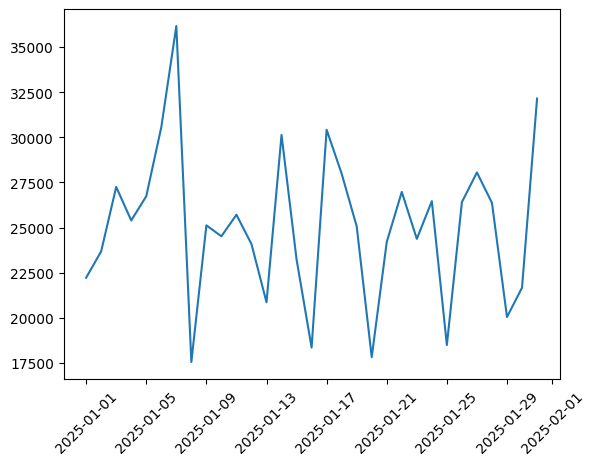

In [19]:
#Let's check if there is a "Tipping Point" when profit becomes especially low.#

daily_profit = (orders.set_index('Order_Date').resample('D')['Net_profit'].sum())

plt.figure()
plt.plot(daily_profit)
plt.xticks(rotation=45)
plt.show() 

#An analysis of profit dynamics reveals a chaotic decline without a clearly defined structural break. 
#It's impossible to pinpoint a specific date after which profits began to systematically decline.

In [20]:
#It's worth checking whether a particular SKU is causing a particularly large share of losses or not#

total_orders_by_sku = orders.groupby('SKU').size().reset_index(name='count_ord')
red_orders_by_sku = red_orders.groupby('SKU').size().reset_index(name='count_red_ord')
SKU_check = total_orders_by_sku.merge(red_orders_by_sku, on='SKU')
SKU_check['Pct_loss_making_profit'] = (SKU_check['count_red_ord']/SKU_check['count_ord'])*100
SKU_check 

#An analysis of profitability by SKU shows that the decline in profit is distributed relatively evenly—no individual products are demonstrating abnormally high negative contributions. 
#There are no significant outliers or SKUs accounting for a disproportionately large share of losses.

,SKU,count_ord,count_red_ord,Pct_loss_making_profit
0,SKU_E1,242,64,26.446281
1,SKU_E2,268,55,20.522388
2,SKU_E3,251,50,19.920319
3,SKU_H1,391,68,17.391304
4,SKU_H2,353,78,22.096317
5,SKU_O1,232,38,16.379310
6,SKU_O2,251,45,17.928287
7,SKU_O3,212,41,19.339623


In [21]:
#The dataset will be divided into two groups—loss-making and profitable orders—and then the average values of key monetary indicators (Sold_Qty, Net_Price_per_Unit, Price_per_Unit, COGS_per_Unit, Discount) will be compared. 
#This will help determine which specific parameters are driving negative profit and whether the loss is related to cost price, discounts, pricing, or sales volume.

analys_redOrd = red_orders.groupby('SKU')[['Net_Price_per_Unit' , 'Price_per_Unit', 'Sold_Qty', 'COGS_per_Unit', 'Revenue', 'Gross profit', 'Logistics_Cost_per_Unit', 'Extra_costs_per_order', 'Net_profit']].mean().reset_index()
analys_redOrd['Discount_impcat'] = ((analys_redOrd['Price_per_Unit']-analys_redOrd['Net_Price_per_Unit'])/analys_redOrd['Price_per_Unit'])*100
print(analys_redOrd)
print()
print()
print(orders[(orders['Profit_flag'] == 'Stability profit')|(orders['Profit_flag'] == 'Perfect profit')].groupby('SKU')[['Net_Price_per_Unit' , 'Price_per_Unit', 'Sold_Qty', 'COGS_per_Unit', 'Revenue', 'Gross profit', 'Logistics_Cost_per_Unit', 'Extra_costs_per_order', 'Net_profit']].mean().reset_index())

#Low profitability for individual orders is likely due to the high proportion of fixed and logistics costs with an average order volume of 4-6 units, which reduces the efficiency of cost allocation per unit.
#Next, it's advisable to check whether the negative profit is solely due to the low volume of units sold, or whether it is the result of a combination of factors—low selling price and the quantity of goods per order.

      SKU  Net_Price_per_Unit  Price_per_Unit  Sold_Qty  COGS_per_Unit  \
0  SKU_E1           54.766555       60.084531  5.906250      33.828594   
1  SKU_E2           57.377527       63.881091  7.181818      34.796545   
2  SKU_E3           49.703880       54.882000  6.260000      29.216800   
3  SKU_H1           64.030382       70.604853  5.029412      39.637353   
4  SKU_H2           67.865045       73.010769  4.166667      39.518718   
5  SKU_O1           46.566026       51.535000  7.578947      28.804474   
6  SKU_O2           63.621722       69.440000  4.555556      39.096444   
7  SKU_O3           61.958549       67.789024  5.439024      36.181463   

      Revenue  Gross profit  Logistics_Cost_per_Unit  Extra_costs_per_order  \
0  209.642781     79.739656                 7.697500              26.363636   
1  244.144473     92.042836                 7.904727              26.363636   
2  217.068870     88.568670                 7.512200              26.363636   
3  213.915324    

In [22]:
#I will analyze unprofitable orders with more than 10 units sold to determine whether negative profitability is driven solely by low volume or by other factors#

red_orders[red_orders['Sold_Qty'] > 10][['Net_Price_per_Unit', 'COGS_per_Unit', 'Price_per_Unit', 'Sold_Qty', 'Revenue', 'Gross profit' ,'Net_profit']]

#Analysis shows that unprofitable orders are primarily caused by a combination of low selling prices and medium or high unit volumes. This means that even with sufficient order quantities, negative profits persist.
#Thus, the key driver of unprofitability is the price level (or excessive discounts), not just sales volume. Even with a good order volume, an insufficient markup fails to cover the cost price and allocated expenses.

,Net_Price_per_Unit,COGS_per_Unit,Price_per_Unit,Sold_Qty,Revenue,Gross profit,Net_profit
4,25.2195,13.73,29.67,14,353.0730,160.8530,37.749364
6,31.5180,19.24,35.02,15,472.7700,184.1700,43.206364
11,23.3510,14.59,24.58,12,280.2120,105.1320,14.688364
35,30.5710,20.69,32.18,15,458.5650,148.2150,25.251364
51,19.3680,12.87,21.52,13,251.7840,84.4740,-68.639636
...,...,...,...,...,...,...,...
2067,21.1905,11.65,24.93,13,275.4765,124.0265,-14.787136
2088,62.5860,44.78,69.54,11,688.4460,195.8660,41.462364
2109,20.8800,12.83,20.88,17,354.9600,136.8500,-29.083636
2158,17.9180,9.95,21.08,15,268.7700,119.5200,8.106364


In [23]:
#I will determine the number of orders that will result in a good profit...

good_profit = orders[(orders['Profit_flag'] == 'Stability profit')|(orders['Profit_flag'] == 'Perfect profit')]
good_profit_c = good_profit.groupby('Sold_Qty').size().reset_index(name='count_profitable')

total = orders.groupby('Sold_Qty').size().reset_index(name='count_total')
total = total.merge(good_profit_c, on='Sold_Qty')
total['pct'] = (total['count_profitable']/total['count_total'])*100
print(total)
print()
print(good_profit.groupby('Sold_Qty')['Net_Price_per_Unit'].mean().reset_index(name='average_net_price'))

#Analysis shows that the highest profits are generated by orders with either a high net price per unit or a combination of a relatively high price (100+ per unit) and a significant volume of units sold.
#This indicates that consistently positive profits are achieved either through a high unit margin or through a combination of price and volume that effectively covers the cost price and allocated expenses.

    Sold_Qty  count_total  count_profitable        pct
0          1          117                 9   7.692308
1          2          126                58  46.031746
2          3          111                63  56.756757
3          4          100                72  72.000000
4          5          109                75  68.807339
5          6           99                82  82.828283
6          7          110                91  82.727273
7          8          112               100  89.285714
8          9          103                93  90.291262
9         10          122               111  90.983607
10        11          115               104  90.434783
11        12          122               106  86.885246
12        13          118               111  94.067797
13        14           89                85  95.505618
14        15          108               101  93.518519
15        16          110               106  96.363636
16        17          121               110  90.909091
17        